# Using Mars Clock

This notebook shows how some of the basic functionality of Mars Clock works and how it can be used. The methodolgy is based on this publication - https://www.lpl.arizona.edu/~shane/publications/piqueux_etal_icarus_2015.pdf.

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy import units as u
from astropy.time import Time

In [3]:
# Define some constants
mars_solar_day = 24.*u.hour + 39.*u.minute + 35.244*u.second
mars_sol = mars_solar_day # This is what's referred to as a sol
mars_tropical_year_in_sols = 668.5921*mars_solar_day
mars_sidereal_day = 24.*u.hour + 37.*u.min + 22.663*u.second

mars_tropical_year = 668.5921*mars_sol
mars_sidereal_year = 668.5991*mars_sol

# J2000 epoch in Julian date
J2000 = Time('2000-01-01 12:00:00', scale='tt')
float_J2000 = J2000.jd # into a float
float_MJD_2000 = J2000.mjd # into a float

In [50]:
def convert_to_float_delta_J2000(time):
    """
    Converts an astropy.Time object into a Julian day float with J2000 subtracted
    
    Args:
        time (astropy.Time): time or times to convert
        
    Returns:
        float or array of floats
    """
    
    # J2000 epoch in Julian date
    J2000 = Time('2000-01-01 12:00:00', scale='tt')
    float_J2000 = J2000.jd # into a float
    
    float_JD_time = time.jd - float_J2000
    
    return float_JD_time

def convert_to_centuries(time):
    """
    Convert time from days to centuries
    
    Args:
        time (float or array of floats): time in days
        
    Returns:
        time in centuries
    """

    return time/(100.*365.24217)
    
def calc_alpha(delta_J2000, mod_360=True):
    """
    Returns the Sun angle using Eq 2 from Picqueux+ (2015)
    
    Args:
        delta_J2000 (float or array of floats): Julian date difference between desired time and
        J2000 (2000 Jan 1 12:00:00)
        mod_360 (bool, optional): take the modulus with 360 degrees
        
    Returns:
        Sun angle (float or array of floats in degrees)
    """
    
    alpha_0  = 270.389001822 # degrees
    lin_coeff = 0.52403850205 # degrees per day
    quad_coeff = -0.000565452 # degrees per century per century
    
    T_centuries = convert_to_centuries(delta_J2000)
    
    alpha = alpha_0 + lin_coeff*delta_J2000 + quad_coeff*T_centuries*T_centuries
    
    if(mod_360):
        alpha = alpha % 360.
    
    return alpha

def calc_mean_anomaly(delta_J2000):
    """
    Returns the mean anomaly using Eq 3 from Picqueux+ (2015)
    
    Args:
        delta_J2000 (float or array of floats): Julian date difference between desired time and
        J2000 (2000 Jan 1 12:00:00)
        
    Returns:
        mean anomaly (float or array of floats in degrees)
    """
      
    M_0 = 19.38028331517 # degrees
    lin_coeff = 0.52402076345 # degrees per day
    
    return M_0 + lin_coeff*delta_J2000

def calc_eccentricity(delta_J2000):
    """
    Calculate evolving eccentricity from Eq 4 from Picqueux+ (2015)
    
    Args:
        delta_J2000 (float or array of floats): Julian date difference between desired time and
        J2000 (2000 Jan 1 12:00:00)
        
    Returns:
        eccentricity
    """
    
    e0 = 0.093402202
    lin_coeff = 0.000091406
    
    T_centuries = convert_to_centuries(delta_J2000)
    
    return e0 + lin_coeff*T_centuries

def calc_PPS(delta_J2000):
    """
    The planetary perturbation terms from Picqueux+ (2015) - you probably don't need to call this!
    
    Args:
        delta_J2000 (float or array of floats): Julian date difference between desired time and
        J2000 (2000 Jan 1 12:00:00)
    
    Returns:
        planetary perturbation terms (float or array of floats) from Eq 6
    """
    
    # amplitudes in degrees
    amplitudes = np.array([7.0591, 6.0890, 4.4462, 3.8947, 2.4328, 2.0400, 1.7746, 1.34607, 1.03438, 0.88180, 
                           0.72350, 0.65555, 0.81460, 0.74578, 0.58359, 0.42864])*1e-3
    
    # periods in days
    tau = np.array([816.3755210, 1005.8002614, 408.1877605, 5765.3098103, 779.9286472, 901.9431281, 11980.9332471,
                   2882.1147, 4332.2204, 373.07883, 1069.3231, 343.49194, 1309.9410, 450.69255, 256.06036, 
                    228.99145])
    
    # phases in degrees
    phi = np.array([48.48944, 167.55418, 188.35480, 19.97295, 12.03224, 95.98253, 49.00256, 288.7737, 37.9378, 
                    65.3160, 175.4911, 98.8644, 186.2253, 202.9323, 212.1853, 32.1227])
        
    PPS = np.zeros_like(delta_J2000)
    
    for i in range(len(amplitudes)):
        PPS += amplitudes[i]*np.cos(2.*np.pi*delta_J2000/tau[i] + phi[i]*np.pi/180.)
    
    return PPS

def calc_equation_of_center(delta_J2000):
    """
    Eqn 5 from Picqueux+ (2015)
    
    Args:
        delta_J2000 (float or array of floats): Julian date difference between desired time and
        J2000 (2000 Jan 1 12:00:00)
        
    Returns:
        difference between true anomaly and mean motion (float or array of floats)
    """
    
    ecc = calc_eccentricity(delta_J2000)
    # Convert mean anomaly to radians
    mean_anomaly = calc_mean_anomaly(delta_J2000)*np.pi/180.
    
    # various orders of sine of the mean anomaly
    sin_M = np.sin(mean_anomaly)
    sin_2M = np.sin(2.*mean_anomaly)
    sin_3M = np.sin(3.*mean_anomaly)
    sin_4M = np.sin(4.*mean_anomaly)
    sin_5M = np.sin(5.*mean_anomaly)
    sin_6M = np.sin(6.*mean_anomaly)
    
    # various powers of the eccentricity
    ecc2 = ecc*ecc
    ecc3 = ecc2*ecc
    ecc4 = ecc3*ecc
    ecc5 = ecc4*ecc
    ecc6 = ecc5*ecc
    
    # And then the combinations
    sin_M_term = (2.*ecc - ecc3/4. + 5.*ecc5/96.)*sin_M
    sin_2M_term = (5.*ecc2/4. - 11*ecc4/24. + 17*ecc6/192.)*sin_2M
    sin_3M_term = (13.*ecc3/12 - 43.*ecc5/64)*sin_3M
    sin_4M_term = (103./96*ecc4 - 451.*ecc6/480)*sin_4M
    sin_5M_term = 1097.*ecc5/960*sin_5M
    sin_6M_term = 1223.*ecc5/960*sin_6M
    
    return sin_M_term + sin_2M_term + sin_3M_term + sin_4M_term +\
        sin_5M_term + sin_6M_term

def calc_Ls(delta_J2000, mod_360=True):
    """
    Calculate Mars' seasonal angle Ls using Eq 7 from Picqueux+ (2015)
    
    Args:
        delta_J2000 (float or array of floats): Julian date difference between desired time and
        J2000 (2000 Jan 1 12:00:00)
        mod_360 (bool, optional): take the modulus with 360 degrees
    
    Returns:
        Mars' seasonal angle Ls
    
    """
    
    alpha = calc_alpha(delta_J2000)
    nu = calc_equation_of_center(delta_J2000)
    PPS = calc_PPS(delta_J2000)
    
    Ls = alpha + 180./np.pi*nu + PPS
    
    if(mod_360):
        Ls = Ls % 360.
        
    return Ls

In [13]:
ts = Time('2021-02-18 20:55', scale='utc').jd - float_J2000
print(calc_alpha(ts))
print(calc_mean_anomaly(ts))

355.63691926304546
4064.4912446555827


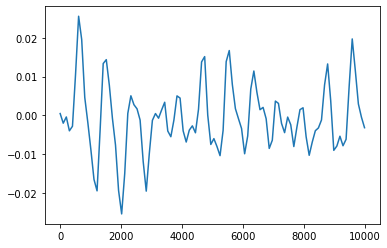

In [27]:
times = np.linspace(0., 10000, 100)
plt.plot(times, calc_PPS(times))

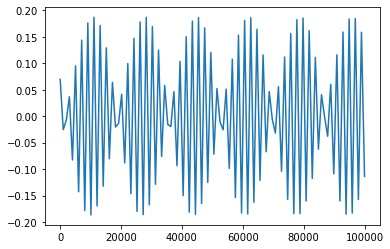

In [22]:
times = np.linspace(0., 100000, 100)
plt.plot(times, calc_equation_of_center(times))

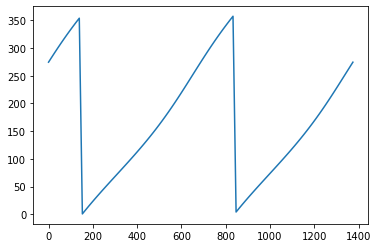

In [31]:
times = np.linspace(0., 2.*mars_tropical_year.to('day').value, 100)
plt.plot(times, calc_Ls(times))

In [76]:
# Testing dates from Picqueux+ (2015) to check for Ls = 0
data = np.genfromtxt("Picqueux2015_Table1.csv", delimiter=',', names=True)

# Dates on which Ls should be equal to zero
dates_delta_J2000 = data["delta_J2000"]
calculated_Ls = calc_Ls(dates_delta_J2000)

# Need to wrap around 360 degrees
ind = calculated_Ls > 350.
calculated_Ls[ind] -= 360.
Picqueux_quoted_accuracy = 0.0073 # degrees

# Check that results agree with zero to within given accuracy
assert(np.all(np.isclose(np.abs(calculated_Ls), 0., rtol=0., atol=Picqueux_quoted_accuracy)))

0.006176610190550491


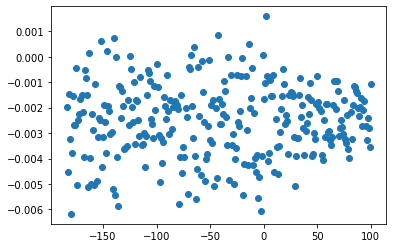

In [72]:
# Testing dates from Picqueux+ (2015) to check for Ls = 0
data = np.genfromtxt("Picqueux2015_Table1.csv", delimiter=',', names=True)
dates_delta_J2000 = data["delta_J2000"]
MYs = data["Mars_year"]

calculated_Ls = calc_Ls(dates_delta_J2000)
# Need to wrap around 360 degrees
ind = calculated_Ls > 350.
calculated_Ls[ind] -= 360.

print(np.max(np.abs(calculated_Ls)))

plt.scatter(MYs, calculated_Ls)

In [49]:
# Check convert_to_float_delta_J2000
test_time = Time("2000-01-01 12:00:00") # J2000
assert(convert_to_float_delta_J2000(test_time) == 0.) # Should be satisifed by definition